In [29]:
import numpy as np
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt
import types

In [6]:
# Load proton spectra from Padovani (and others)
file_W98 = "data/W98.csv"
file_M02 = "data/M02.csv"

w98 = types.SimpleNamespace()
w98.energy, w98.spectrum = np.loadtxt(file_W98, delimiter=',', comments='#', unpack=True)

m02 = types.SimpleNamespace()
m02.energy, m02.spectrum = np.loadtxt(file_M02, delimiter=',', comments='#', unpack=True)

# Load Energy loss functions L(E) from Padovani
file_electrons = "data/energyLoss_electrons.csv"
file_protons = "data/energyLoss_protons.csv"

pLoss = types.SimpleNamespace()
pLoss.E, pLoss.L = np.loadtxt(file_protons, delimiter=',', comments='#', unpack=True)

eLoss = types.SimpleNamespace()
eLoss.E, eLoss.L = np.loadtxt(file_electrons, delimiter=',', comments='#', unpack=True)

pLoss.Einterp = np.logspace(-0.8, 10.9, num=2000, endpoint=True)
fint = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True)
pLoss.Linterp = fint(pLoss.Einterp)

def plotPadovaniFigs(w98, m02, pLoss, eLoss):
    plt.clf()
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].loglog(w98.energy, w98.spectrum, 'k-', label="W98")
    axs[0].loglog(m02.energy, m02.spectrum, 'r-', label="M02")
    axs[0].set_xlim(1,1e11)
    axs[0].set_ylim(1e-16,1)
    axs[0].set_xlabel("Energy [eV]")
    axs[0].set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
    axs[0].legend()

    axs[1].loglog(pLoss.E, pLoss.L, 'k--', label="p")
    axs[1].loglog(pLoss.Einterp, pLoss.Linterp, 'k-', label="pint")
    axs[1].loglog(eLoss.E, eLoss.L, 'r-', label="e")
    axs[1].set_xlabel("Energy [eV]")
    axs[1].set_ylabel("L(E) [10$^{-16}$ eV cm$^2$]")
    axs[1].set_xlim(1e-1,1e11)
    axs[1].set_ylim(1e-3,2e2)
    axs[1].legend()
    fout = 'out/spectraAndEnergyLossFunctions.pdf'
    plt.savefig(fout)
    plt.savefig(fout.replace(".pdf",".png"))

In [7]:
# Compute the range of a particle (proton) given an energy loss function
# by integrating the energy loss function until the particle is at rest.
def rangeOfE(EE, dEdN):
    # Einit: initial particle energy [eV]
    # dEdN: energy loss function (1e-16 eV cm2)
    # EE: corresponding energies for dEdN (eV)
    dE = EE[1:]-EE[:-1]

    ranges = []
    #nn = len(dEdN)-1
    nn = len(dE)
    
    integrand = dE/dEdN[1:]
    for ii in range(nn):
        ranges.append(np.sum(integrand[0:ii]))

    return ranges

<Figure size 432x288 with 0 Axes>

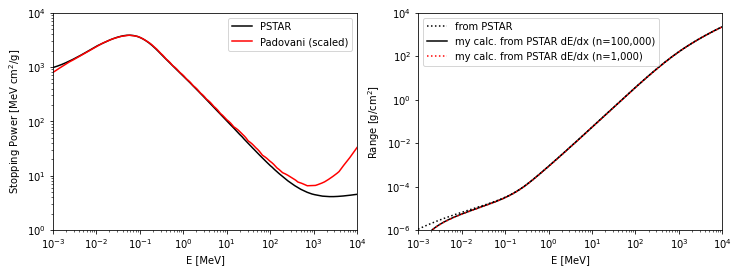

In [8]:
# data from NIST
plt.clf()
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(12,4) )

fname = 'data/pstar_stopping_hydrogen.dat'
pstar = types.SimpleNamespace()
pstar.E, pstar.dEdx, pstar.range = np.loadtxt(fname, delimiter=None, comments='#', unpack=True)

# interpolate
pstar.Einterp = np.logspace(-3, 4, num=100000, endpoint=True)
fint0 = scipy.interpolate.interp1d(pstar.E, pstar.dEdx, kind='linear', assume_sorted=True)
pstar.dEdxInterp = fint0(pstar.Einterp)

# coarser interpolation (check if range discrepancy at low proton energy is due to resolution)
# Answer: it's not.
pstar.Einterp2 = np.logspace(-3, 4, num=1000, endpoint=True)
fint2 = scipy.interpolate.interp1d(pstar.E, pstar.dEdx, kind='linear', assume_sorted=True)
pstar.dEdxInterp2 = fint2(pstar.Einterp2)

#axs[0].loglog(pstar.E, pstar.dEdx, 'k--')
axs[0].loglog(pstar.Einterp, pstar.dEdxInterp, 'k-', label='PSTAR')
axs[0].loglog(pLoss.Einterp*1e-6, pLoss.Linterp*30, 'r-', label='Padovani (scaled)')
axs[0].set_xlim(1e-3, 1e4)
axs[0].set_ylim(1e0, 1e4)
axs[0].set_xlabel("E [MeV]")
axs[0].set_ylabel("Stopping Power [MeV cm$^2$/g]")
axs[0].legend()

rng = rangeOfE(pstar.E, pstar.dEdx)
rngInterp = rangeOfE(pstar.Einterp, pstar.dEdxInterp)
rngInterp2 = rangeOfE(pstar.Einterp2, pstar.dEdxInterp2)
axs[1].loglog(pstar.E, pstar.range, 'k:', label='from PSTAR')
axs[1].loglog(pstar.Einterp[1:], rngInterp, 'k-', label='my calc. from PSTAR dE/dx (n=100,000)')
axs[1].loglog(pstar.Einterp2[1:], rngInterp2, 'r:', label='my calc. from PSTAR dE/dx (n=1,000)')
#axs[1].loglog(pstar.E[1:], rng, 'k--')
axs[1].set_xlim(1e-3, 1e4)
axs[1].set_ylim(1e-6, 1e4)
axs[1].set_xlabel("E [MeV]")
axs[1].set_ylabel("Range [g/cm$^2$]")
axs[1].legend()
fout = "out/stoppingAndRange.pdf"
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

nn, min, max of pLoss.Einterp: 2000, 0.15848931924611134, 79432823472.42822


<Figure size 432x288 with 0 Axes>

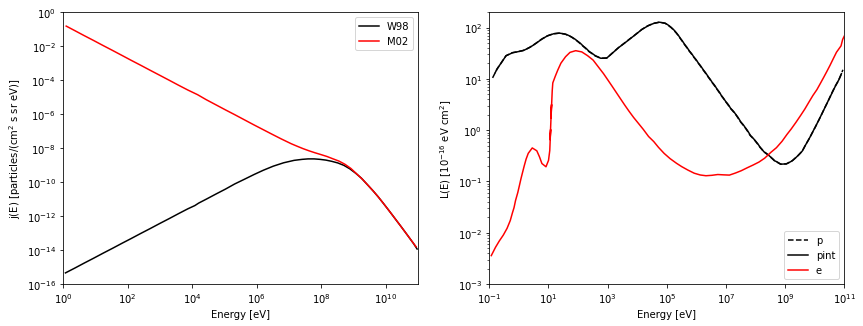

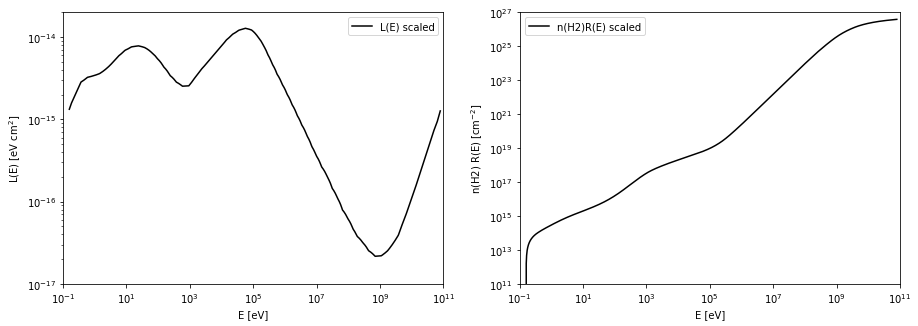

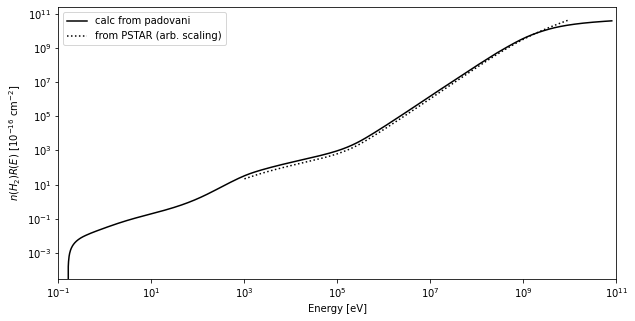

In [21]:
# Follow procedure in Padovani to find j(E,N) from j(E0,0)

# FIXME: update padovani's L(E) to include energies all the way down to 0.1eV and up to 100 GeV (re-do webplotdigitizer!)

# Vary E and E0 from 0.1eV to 100 GeV, determine column density from the difference betwen R(E0) and R(E)
# N(H2) ~ R(E0)-R(E) (see Padovani Equation 21)
# Make contour plot of N(H2) vs. E0 and E
# Pick a single contour (a fixed value of N(H2)) and fit E0 = (cE^b + N/N0)^(1/b)
#.   this tells us what the starting energy E0 is for a given ending energy E
# Once you know the E0 <--> E mapping, you can compute j(E,N) from j(E0,0) and L(E0)/L(E)

print(f'nn, min, max of pLoss.Einterp: {len(pLoss.Einterp)}, {min(pLoss.Einterp)}, {max(pLoss.Einterp)}')

RR = rangeOfE(pLoss.Einterp, pLoss.Linterp)  
# units of pLoss.Linterp are 1e-16 eV cm^2, so "range" is really n(H2)*R(E) and has units of 1e16 cm^{-2}

# convert Linterp to units of eV cm^2
pLossScaled = types.SimpleNamespace()
pLossScaled.E = pLoss.Einterp[:]
pLossScaled.L = pLoss.Linterp[:]*1e-16
RRscaled = rangeOfE(pLossScaled.E, pLossScaled.L)  


# Compute level contours of N(H2)/n(H2) =  R(E0)-R(E)
E0, EE = np.meshgrid(pLoss.Einterp[1:], pLoss.Einterp[1:])
R0, RE = np.meshgrid(RR, RR)
NN = R0-RE

# Scaled versions
E0s, EEs = np.meshgrid(pLossScaled.E[1:], pLossScaled.E[1:])
R0s, REs = np.meshgrid(RRscaled, RRscaled)
NNs = R0s-REs

plotPadovaniFigs(w98, m02, pLoss, eLoss)

figN, axN = plt.subplots(1, 2, figsize=(15,5))
axN[0].loglog(pLossScaled.E, pLossScaled.L, 'k-', label='L(E) scaled')
axN[0].set_xlim(1e-1, 1e11)
axN[0].set_ylim(1e-17, 2e-14)
axN[0].set_xlabel("E [eV]")
axN[0].set_ylabel("L(E) [eV cm$^2$]")
axN[0].legend()

axN[1].loglog(pLossScaled.E[1:], RRscaled, 'k-', label='n(H2)R(E) scaled')
axN[1].set_xlim(1e-1, 1e11)
axN[1].set_ylim(1e11, 1e27)
axN[1].set_xlabel("E [eV]")
axN[1].set_ylabel("n(H2) R(E) [cm$^{-2}$]")
axN[1].legend()

# Visualize the Range vs. Energy data...
fig2, axs2 = plt.subplots(figsize=(10,5))
axs2.loglog(pLoss.Einterp[1:], RR, 'k-', label='calc from padovani')
axs2.loglog(pstar.E*1e6, pstar.range*2e7, 'k:', label='from PSTAR (arb. scaling)')
axs2.set_xlabel("Energy [eV]")
axs2.set_ylabel("$n(H_2) R(E)$ [$10^{-16}$ cm$^{-2}$]")
axs2.set_xlim(1e-1,1e11)
axs2.legend()
fout = 'out/rangePadovani.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

[7.94328235e+10 7.91486907e+10 7.83694996e+10 ... 1.13425970e+09
 1.13425970e+09 1.13425970e+09]
0.16063971555631523


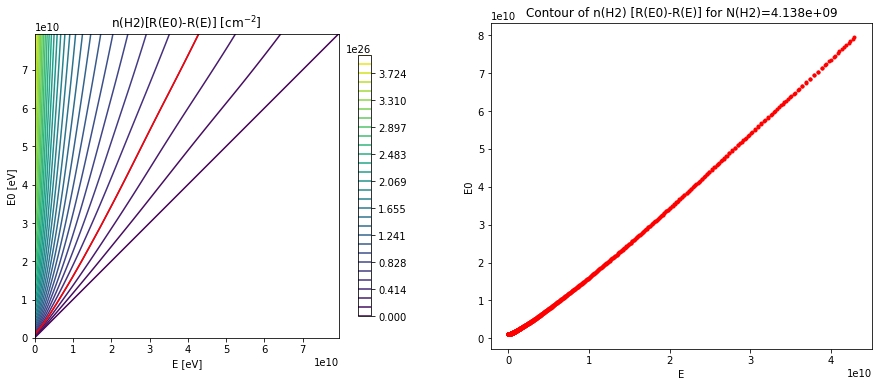

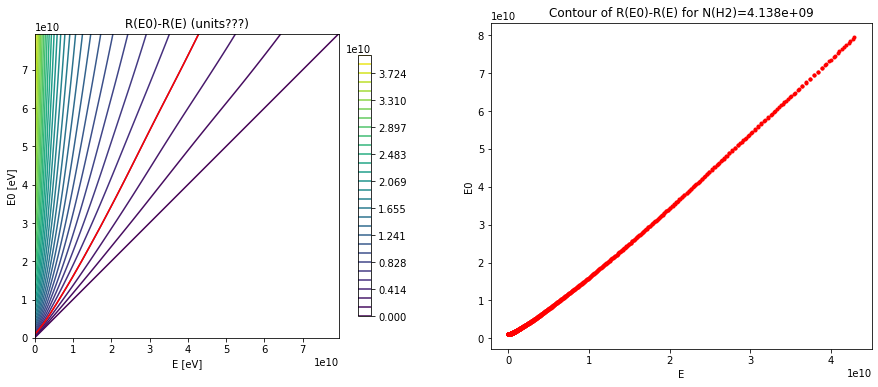

In [28]:
# VISUALIZE N(H2) CONTOURS
fig4, axs4 = plt.subplots(1, 2, figsize=(15,6))
levelMax = 4e26
levels = np.linspace(0, levelMax, num=30)
#levels = 30
cs = axs4[0].contour(EEs, E0s, NNs, levels=levels)
axs4[0].axis('scaled')
axs4[0].set_xlabel("E [eV]")
axs4[0].set_ylabel("E0 [eV]")
axs4[0].set_title("n(H2)[R(E0)-R(E)] [cm$^{-2}$]")
fig4.colorbar(cs, ax=axs4[0], shrink=0.8)

levelId = 3
NH2s = levels[levelId]
dat0 = cs.allsegs[levelId][0]
xEs  = dat0[:,0]
yE0s = dat0[:,1]

axs4[0].plot(xEs, yE0s, 'r-') # overplot on contour graph
axs4[1].plot(xEs, yE0s, 'r.')
axs4[1].set_xlabel("E")
axs4[1].set_ylabel("E0")
axs4[1].set_title(f"Contour of n(H2) [R(E0)-R(E)] for N(H2)={NH2:.3e}")



# VISUALIZE N(H2) CONTOURS
fig3, axs3 = plt.subplots(1, 2, figsize=(15,6))
levelMax = 4e10
levels = np.linspace(0, levelMax, num=30)
cs = axs3[0].contour(EE, E0, NN, levels=levels)
axs3[0].axis('scaled')
axs3[0].set_xlabel("E [eV]")
axs3[0].set_ylabel("E0 [eV]")
axs3[0].set_title("R(E0)-R(E) (units???)")
fig3.colorbar(cs, ax=axs3[0], shrink=0.8)

# Extract a single contour to get E vs. E0 for a single value of N(H2)
levelId = 3
NH2 = levels[levelId]
dat0= cs.allsegs[levelId][0]
xE  = dat0[:,0]
yE0 = dat0[:,1]

print(yE0)
print(min(xE))

axs3[0].plot(dat0[:,0],dat0[:,1], 'r-')

axs3[1].plot(xE, yE0, 'r.')
axs3[1].set_xlabel("E")
axs3[1].set_ylabel("E0")
axs3[1].set_title(f"Contour of R(E0)-R(E) for N(H2)={NH2:.3e}")

fout = 'out/NH2Contours.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

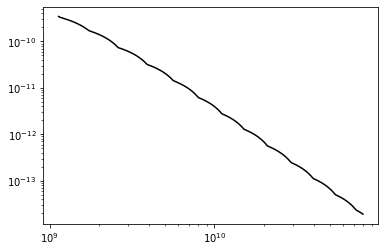

In [42]:
# interpolate L(E) onto our E0 and E values
fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True) # FIXME: this is a repeat from above...
LE_E0 = fint_LE(yE0s)
LE_E  = fint_LE(xEs)

# interpolate j(E0,0) onto our E0 values
fint_w98 = scipy.interpolate.interp1d(w98.energy, w98.spectrum, kind='linear', assume_sorted=True) 
jjw98 = fint_w98(yE0s)

nE = len(yE0s)
jjDegraded = []
for ii in range(nE):
    Ei = xEs[ii]
    E0i = yE0s[ii]
    jjDegraded.append( fint_w98(E0i)*fint_LE(E0i)/fint_LE(Ei) )
    
jjDegraded = np.array(jjDegraded)

plt.loglog(yE0s, jjw98, 'k-')
#plt.loglog(xEs, jjDegraded, 'k--')
    
    
    

In [ ]:
# Fit a function E0 = (cE^b + N/N0)^(1/b)
def E0vsE(x, N, c, b, N0):
    #arg = c*np.power(x,b)+N/N0
    arg = c*x**b+N/N0
    return np.power(arg , 1.0/b)

p0 = (NH2, 1.7, 1.8, 0.9)
popt, pcov = curve_fit(E0vsE, xE, yE0, p0=p0,
                        bounds=([0.99999*NH2, -np.inf, -np.inf, -np.inf], [NH2, np.inf, np.inf, np.inf]))
print(popt)
yfit = E0vsE(xE, *popt)
axs[1].plot(xE, E0vsE(xE, *popt), 'r--')

In [39]:
# # interpolate the E0(E) curve onto the values of E 
# ids = np.where( (pLoss.Einterp > np.min(xEs)) & (pLoss.Einterp < np.max(xEs)) )[0]
# xEsInterp = pLoss.Einterp[ids]
# print(np.min(xEs))
# print(np.min(xEsInterp))
# print(np.max(xEs))
# print(np.max(xEsInterp))
# print(len(xEs))
# print(len(xEsInterp))

# fint5 = scipy.interpolate.interp1d(xEs, yE0s, kind='linear', assume_sorted=True)
# yE0sInterp = fint5(xEsInterp)
# #plt.plot(xEs, yE0s, 'r.')
# #plt.plot(xEsInterp, yE0sInterp, 'k--')

0.16063971555631523
0.16281928862311654
42874394950.31847
42733196780.78163
2269
1952


ValueError: A value in x_new is below the interpolation range.